In [1]:
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

import gigatl_lib as gl

%matplotlib inline

In [2]:
def findLatLonIndex(ds, lonValue, latValue):
        ''' Find nearest  grid point of  click value '''
        a = abs(ds['xi_rho'] - lonValue) + \
            abs(ds['eta_rho'] - latValue)
        return np.unravel_index(a.argmin(), a.shape)

In [3]:
def findDepthIndex(z, depth):
        ''' Find nearest  grid point'''
        a = abs(z - depth)
        return xr.DataArray(a.argmin(dim='s_rho'))

In [4]:
from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=10)
client = Client(cluster)
client

/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: inproc://134.246.146.72/6760/1 Dashboard: http://134.246.146.72/6760/1:33959/status,Cluster Workers: 1 Cores: 10 Memory: 67.17 GB


In [5]:
# On récupère la liste des fichiers à ouvrir via le fichier liste 
path = "/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/"
#filenames = path + pd.read_csv('liste.122014',header=None)
filenames = path + pd.read_csv('liste.2014',header=None)
filenames = filenames.values.flatten().tolist()
filenames
    

['/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-01-02-2014-01-06.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-01-07-2014-01-11.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-01-12-2014-01-16.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-01-17-2014-01-21.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-01-22-2014-01-26.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-01-27-2014-01-31.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-02-01-2014-02-05.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-02-06-2014-02-10.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-02-11-2014-02-15.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/GIGATL6_12h_inst_2014-02-16-2014-02-20.nc',
 '/home/datawork-lops-megatl/GIGATL6/GIG

In [6]:
datasets = []
for f in filenames:
    ds = xr.open_dataset(f, chunks={'time_counter': 1, 's_rho': 1},
                         drop_variables=['ubar', 'vbar', 'sustr', 'svstr','w',
                                         'temp','salt', 'hc','theta_s','theta_b',
                                         'Tcline','Vtransform','pm','pn','h','f','angle',
                                         'mask_rho','Cs_r','sc_r','Cs_w','sc_w','lon_rho',
                                         'lat_rho','lon_u','lat_u','lon_v','lat_v'])
    datasets.append(ds)
ds = xr.concat(datasets, dim='time_counter', coords='minimal', compat='override')

In [7]:
# On ajoute dans le dataset les paramètres de grille qui sont dans le 1ier fichier
path = "/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h/HIS/"
gridname = path+'GIGATL6_12h_inst_2004-01-15-2004-01-19.nc'
gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
ds['hc'] = gd.hc
ds['h'] = gd.h
ds['Vtransform'] = gd.Vtransform
ds['sc_r'] = gd.sc_r
ds['sc_w'] = gd.sc_w
ds['Cs_r'] = gd.Cs_r
ds['Cs_w'] = gd.Cs_w
ds['angle'] = gd.angle
ds['mask_rho'] = gd.mask_rho

In [8]:
# On modifie des dimensions et des coordonnées, on crée la grille xgcm
ds = gl.adjust_grid(ds)
L = ds.dims['x_rho']
M = ds.dims['y_rho']
N = ds.dims['s_rho']

In [9]:
# On crée la grille xgcm
ds = gl.xgcm_grid(ds)
grid = ds.attrs['xgcm-Grid']

In [10]:
# compute time step for temporal animation
# writing step in input files : 12h
dt = ( 12.* 3600.)
# keep one step per day
#step = int(86400. / dt)
step = int(10*86400. / dt)
ds2 = ds.isel(time_counter=slice(0,None,step))
ds2

<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, s_rho: 50, s_w: 51, time_counter: 37, x_rho: 1502, x_u: 1501, y_rho: 2002, y_v: 2001)
Coordinates:
    eta_rho              (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_w                 (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_rho               (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    eta_u                (y_rho, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    xi_u                 (y_rho, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    eta_v                (y_v, x_rho) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    eta_w                (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_v                 (y_v, x_rho) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
  * s_w                  (s_w) float32 -1.0 -0.98

In [11]:
# Find index of given longitude/latitude
lonValue = -30.
latValue = 0.
latindex, lonindex = findLatLonIndex(ds2, lonValue, latValue)
print(latindex, lonindex)
print(ds2.xi_rho.values[838,768],ds2.eta_rho.values[838,768])

838 768
-30.004793 -0.005113315


In [12]:
# extract u and interpolate at rho point
u = ds2.u.isel(x_u=slice(lonindex,lonindex+2),y_rho=latindex)
u = grid.interp(u,'xi',boundary=None).isel(x_rho=1)
print(u)

<xarray.DataArray 'mul-cbe2540312906321071171caa9a967f5' (time_counter: 37, s_rho: 50)>
dask.array<getitem, shape=(37, 50), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01


In [13]:
# extract v and interpolate at rho point
v = ds2.v.isel(y_v=slice(latindex,latindex+2),x_rho=lonindex)
v = grid.interp(v,'eta',boundary=None).isel(y_rho=1)
print(v)

<xarray.DataArray 'mul-475942310daaab77390963a882f7b81b' (time_counter: 37, s_rho: 50)>
dask.array<getitem, shape=(37, 50), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01


In [14]:
# extract angle
angle = ds2.angle.isel(x_rho=lonindex, y_rho=latindex)

In [15]:
# Compute vrot
vrot = u*np.sin(angle) + v*np.cos(angle)
vrot

<xarray.DataArray (time_counter: 37, s_rho: 50)>
dask.array<add, shape=(37, 50), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01

In [16]:
# Compute depth at rho point
z_r = gl.get_z(ds2,zeta=ds2['zeta'],hgrid='r').isel(x_rho=lonindex, y_rho=latindex).persist()
z_r

/home1/dunree/slgentil/.miniconda3/envs/croco/lib/python3.7/site-packages/dask/array/core.py:3851: PerformanceWarning: Increasing number of chunks by factor of 37
  **blockwise_kwargs
/home1/dunree/slgentil/models/croco/gigatl/gigatl_lib.py:152: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(*('time_counter',zdim,ydim,xdim))


<xarray.DataArray 'z_r' (time_counter: 37, s_rho: 50)>
dask.array<getitem, shape=(37, 50), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       float32 -0.005113315
    xi_w          float32 -30.004793
    xi_rho        float32 -30.004793
    eta_w         float32 -0.005113315
    time_instant  (time_counter) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00
  * time_counter  (time_counter) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01

In [17]:
# Compute Indices of nearest depth (not interpolated depth)
depth = -1000.
zIndex = findDepthIndex(z_r,depth)
zIndex

<xarray.DataArray 'z_r' (time_counter: 37)>
array([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21])
Coordinates:
    eta_rho       float32 -0.005113315
    xi_w          float32 -30.004793
    xi_rho        float32 -30.004793
    eta_w         float32 -0.005113315
    time_instant  (time_counter) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00
  * time_counter  (time_counter) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00

In [18]:
vrot.coords['z'] = z_r
vrot.coords['time'] = vrot.time_counter.expand_dims({'s_rho': N},axis=1)
vrot

<xarray.DataArray (time_counter: 37, s_rho: 50)>
dask.array<add, shape=(37, 50), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    eta_rho       float32 -0.005113315
    xi_w          float32 -30.004793
    xi_rho        float32 -30.004793
    eta_w         float32 -0.005113315
    time_instant  (time_counter) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00
    z             (time_counter, s_rho) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    time          (time_counter, s_rho) datetime64[ns] 2014-01-02T12:00:00 ... 2014-12-28T12:00:00

CPU times: user 2.17 s, sys: 268 ms, total: 2.44 s
Wall time: 6.03 s


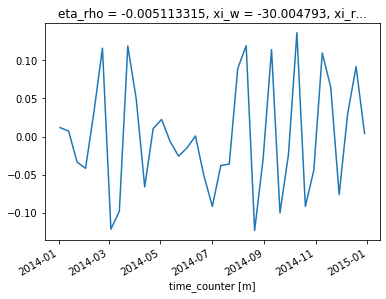

In [19]:
%%time
#plot v at lon,lat,depth  in time
vrot[:,zIndex].plot()

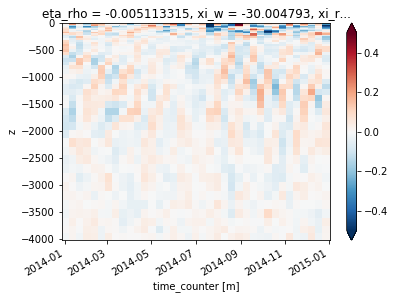

In [20]:
# Plot v(z) at lon/lat in time
vrot.plot(x='time',y='z',vmin=-0.5, vmax=0.5, cmap = 'RdBu_r')
#vrot.plot()

/home1/dunree/slgentil/models/croco/gigatl/gigatl_lib.py:155: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(*(zdim,)+_zeta.dims)


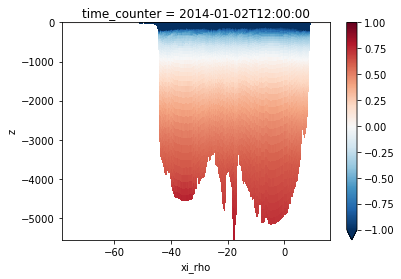

In [40]:
ds2 = ds.isel(time_counter=0)
z = gl.get_z(ds2,zeta=ds2['zeta'])
vnew = gl.slice(ds2,ds2.rho,z,latitude=0.)
vnew.plot(x=[s for s in vnew.coords if "xi_" in s][0],
          y=[s for s in vnew.coords if "z" in s][0],
          vmin=-1., vmax=1., cmap = 'RdBu_r')

<xarray.DataArray 'rho' (s_rho: 50, x_rho: 1502)>
dask.array<getitem, shape=(50, 1502), dtype=float32, chunksize=(1, 1502), chunktype=numpy.ndarray>
Coordinates:
    eta_rho       (x_rho) float32 dask.array<chunksize=(1502,), meta=np.ndarray>
    xi_w          (x_rho) float32 dask.array<chunksize=(1502,), meta=np.ndarray>
    xi_rho        (x_rho) float32 dask.array<chunksize=(1502,), meta=np.ndarray>
    eta_w         (x_rho) float32 dask.array<chunksize=(1502,), meta=np.ndarray>
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    time_instant  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time_counter  datetime64[ns] 2014-01-02T12:00:00
Dimensions without coordinates: x_rho
Attributes:
    long_name:           density anomaly
    units:               kilogram meter-3
    online_operation:    instant
    interval_operation:  12 h
    interval_write:      12 h
    cell_methods:        time: point


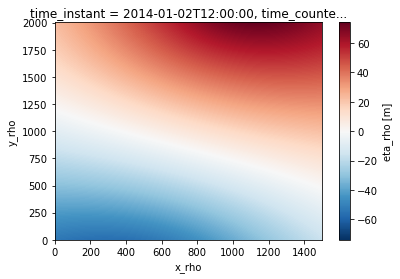

In [47]:
rho = ds2.rho.isel(y_rho=800)
print(rho)
#rho.plot(x='xi_rho',y="s_rho",vmin=-1., vmax=1., cmap = 'RdBu_r')
ds2.eta_rho.plot()